In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

from scipy import sparse
from scipy.sparse import linalg

from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Learning the Finite Element Method. Step 0 

We start with the simplest setting in 1D.

## Simple problem definition
We  solve the following diffusion + reaction equation, with a source term:

$$ -\frac{d}{dx}D\frac{du}{dx} + \sigma u = q \qquad \forall x \in [0,L]$$

We will assume all material properties $D, \sigma,q$ to be constant for now.

We use the following boundary conditions:
* at $x=0$, we impose a value $ u(0)=u_{\text{left}}$
* at $x=L$, we impose a value $ u(L)=u_{\text{right}}$

These conditions are known as Dirichlet boundary conditions.

## Meshing the domain
The interval $[0,L]$ is meshed using $N$ cells. In FEM, meshcells are known as '*elements*'. The vertices of the mesh are denoted by $x_i$ and there are $N+1$ vertices. Obviously, $x_0=0$ and $x_N=L$.

## Choice of solution space
We will approximate the solution to the above problem as a **piece-wise linear** function. Between two consecutive vertices, the function is linear, as shown in the plot below.

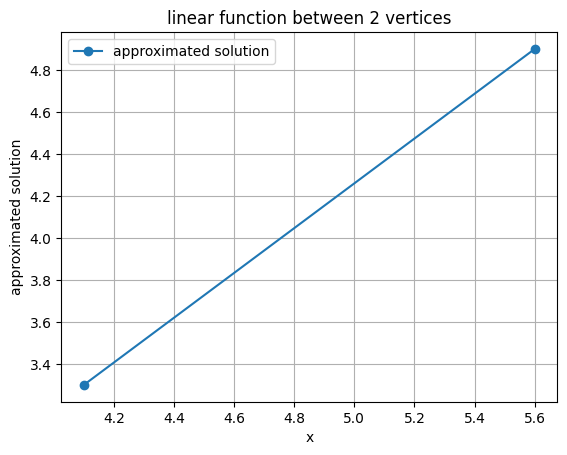

In [2]:
vertices = [4.1, 5.6]
values   = [3.3, 4.9]

plt.figure()
plt.plot(vertices, values, marker='o', label='approximated solution')
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.ylabel('approximated solution')
plt.title('linear function between 2 vertices')
plt.show()

So, a **piece-wise linear** function will look like this:

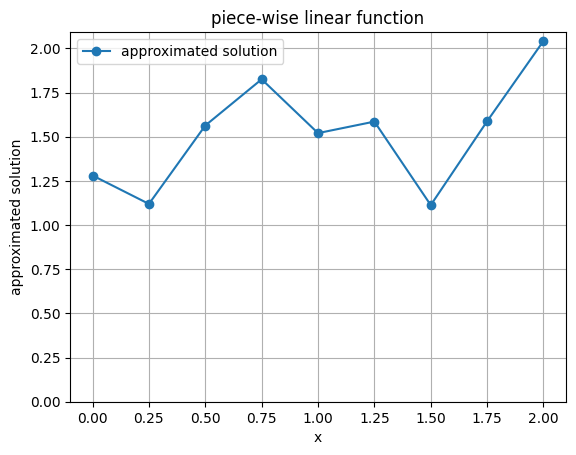

In [3]:
# we fix a starting seed to always get the same plot
np.random.seed(11)

# vertices and values
x = np.linspace(0,2,9)
u  = np.random.rand(len(x))+1.1

plt.figure()
plt.plot(x, u, marker='o', label='approximated solution')
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.ylabel('approximated solution')
plt.title('piece-wise linear function')
plt.ylim([0,np.max(u)+0.05])
plt.show()

It is important to note that the nodal values of the solution (the values at the vertices) will be the solution of the discrete linear system we will be setting up soon.

## Introducing basis functions

A piece-wise linear function can be represented as follows

$$ u(x) = \sum_i u_i b_i(x) $$

where the basis function $b_i(x)$ is a piece-wise linear function that:
* is only non-zero on the element $[x_{i-1},x_i]$ and the element $[x_i,x_{i+1}]$
* reaches a value of 1 at $x_i$ $$ b_i(x_i)=1$$
* is zero at $x_{i-1}$ and $x_{i+1}$

In full detail
$$
b_i(x)  =
\begin{cases}
\frac{x-x_{i-1}}{x_{i}-x_{i-1}} \quad\text{when } x\in [x_{i-1},x_i]\\
\\
\frac{x_{i+1}-x}{x_{i+1}-x_{i}} \quad\text{when } x\in [x_i,x_{i+1}] \\
\\
0 \qquad\text{elsewhere}
\end{cases}
$$
For example, using the above data, I plot $b_5(x)$

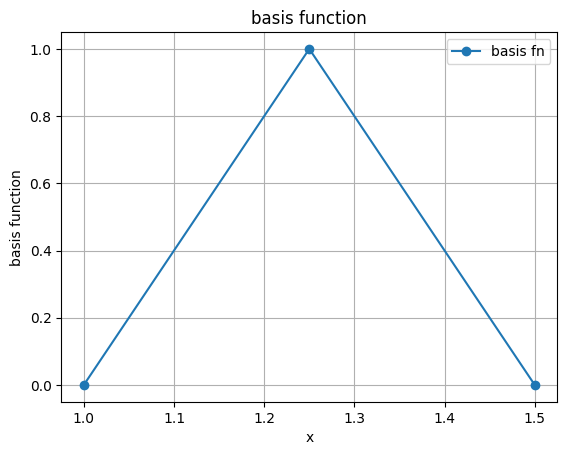

In [4]:
vertices = [x[4], x[5], x[6]]
values  = [0,1,0]

plt.figure()
plt.plot(vertices, values, marker='o', label='basis fn')
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.ylabel('basis function')
plt.title('basis function')
plt.show()

So, let us plot again the piece-wise linear $u(x)$ from before, but also show all of the basis functions

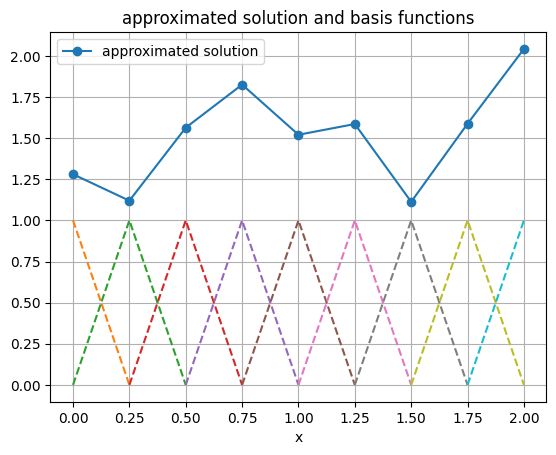

In [5]:
plt.figure()
plt.plot(x, u, marker='o', label='approximated solution')

Npts = len(x)
for i in range(0,Npts):
    if i==0:
        vertices = [x[i], x[i+1]]
        values   = [1,0]
        plt.plot(vertices, values, '--')
    elif i==Npts-1:
        vertices = [x[i-1], x[i]]
        values   = [0,1]
        plt.plot(vertices, values, '--')
    else:
        vertices = [x[i-1], x[i], x[i+1]]
        values   = [0,1,0]
        plt.plot(vertices, values, '--')
  
   
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.title('approximated solution and basis functions')
plt.show()

Note that on a given element $i$ consisting of the segment $[x_i,x_{i+1}]$, only two basis functions are not uniformly zero; these 2 non-zero functions are:
- $b_i(x)$ and
- $b_{i+1}(x)$

They are plotted below

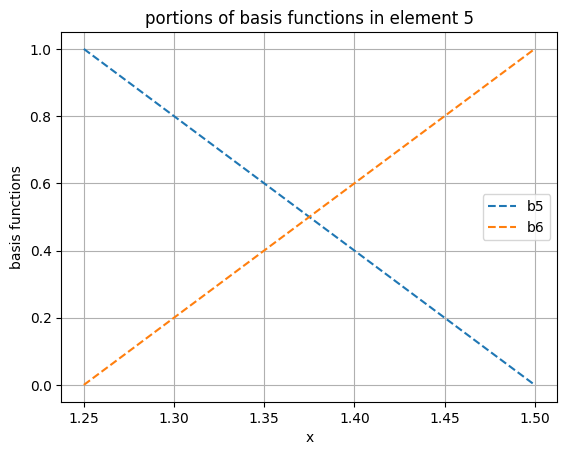

In [6]:
iel=5

vertices = [x[iel], x[iel+1]]
b5_values  = [1,0]
b6_values  = [0,1]

plt.figure()
plt.plot(vertices, b5_values, linestyle='--', label='b'+str(iel))
plt.plot(vertices, b6_values, linestyle='--', label='b'+str(iel+1))
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.ylabel('basis functions')
plt.title('portions of basis functions in element '+str(iel))
plt.show()

The plot over the entire mesh, showing only basis functions 5 and 6 over element 5 is below, with element 5 highlighted.

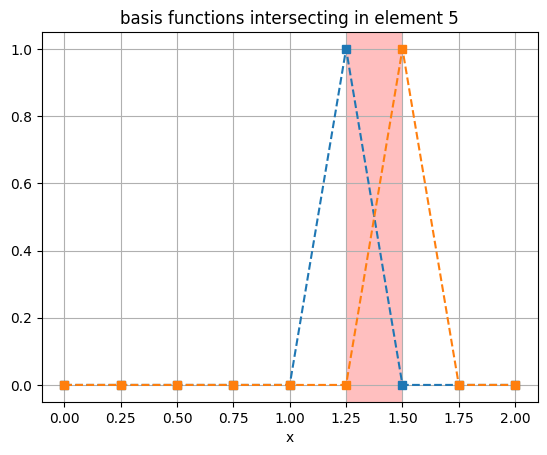

In [7]:
plt.figure()

for i in range(0,Npts):
    values = np.zeros_like(x)
    if i==5 or i==6:
        values[i]   = 1
        plt.plot(x, values, 's--')

plt.axvspan(x[iel], x[iel+1], facecolor='red', alpha=0.25) 
plt.grid(True)
plt.xlabel('x')
plt.title('basis functions intersecting in element '+str(iel))
plt.show()

## Weak form

We know that our piece-wise linear function is not the true exact solution of the problem (except in rare situations when the exact answer is also piece-wise linear). So we denote our approximate solution by

$$ u_h(x) = \sum_{j=0}^{j=N} u_j b_j(x) $$

where the subscript $h$ denotes the typical meshsize of the domain. Note that I have changed the dummy index to now be $j$. Think of $j$ as being the index for columns in a matrix. This will become clearer later. 

If we report our approximate solution in the equation, we get:

$$ -\frac{d}{dx}D\frac{du_h}{dx} + \sigma u_h \ne q \qquad \forall x \in [0,L]$$
(As $u_h$ is an approximation to our solution, we do not expect the equality to hold for every $x$. There should exist some residual function $R(u_h)$ defined as:
$$R(u_h):=q-(-\frac{d}{dx}D\frac{du_h}{dx}+\sigma u_h)$$
That is why the inequality.)

This is not very useful. First, our approximate solution cannot be differentiated twice in $x$. Second, we need to obtain equations **for all** of the unknown nodal values $u_j$ with $0 \le j \le N$.

One way to solve these issues is to integrate that equation over the entire domain (getting rid of the $x$ variable)

$$ \int_0^L dx \left( -\frac{d}{dx}D\frac{du_h}{dx} + \sigma u_h \ne q \right)$$
or
$$ -\left.D\frac{du_h}{dx}\right|_L + \left.D\frac{du_h}{dx}\right|_0 + \int_0^L dx \, \sigma u_h =  \int_0^L dx  q $$

(That is we integrate both side of the equality of the original equation and expect that the results are equal for some combination of $u_j$ s.) The derivatives can be expressed as functions of $u_0, u_1$, and $u_{N-1},u_N$ and the integral on the left-hand-side will depend on all values of $u_j$. This is not very useful, still, because all the unknowns are present in a single equation. We need **more equations!**

How many equations do we need? We need $N+1$ equations because we have $N$ segments and thus $N+1$ vertices.

How many basis functions do we have? We have $N+1$.

There is the answer. We will integrate the governing law over space. But, before doing this, we will multiply our governing law by **any** of those $N+1$ basis functions. **We call this 'multiplying by a test function'**. Let us denote by $b_i(x)$ any of those $N+1$ possible choices. The index $i$ will denotes each equation we will derive. Think of $i$ as the being the index for rows in a matrix.

* Step-0: multiply governing law by $b_i(x)$ for any $0 \le i \le N$ 
$$\phantom{a}$$ 
$$ -b_i(x)\frac{d}{dx}D\frac{du_h}{dx} + b_i(x)\sigma u_h \ne b_i(x)q \qquad \forall x \in [0,L]$$
$$\phantom{a}$$ 

* Step-1: integrate over the entire space 
$$\phantom{a}$$ 
$$ \int_0^L dx \, b_i(x)\left( -\frac{d}{dx}D\frac{du_h}{dx} + \sigma u_h \ne q \right)$$
$$\phantom{a}$$ 
 
* Step-2: integrate by parts the double derivative term 
$$\phantom{a}$$ 
$$ -\left.b_i(x)D\frac{du_h}{dx}\right|_L + \left.b_i(x)D\frac{du_h}{dx}\right|_0 + \int_0^L dx \, \left( \frac{db_i}{dx}D\frac{du_h}{dx} + b_i\sigma u_h \right) = \int_0^L dx \, \left( b_i(x) q \right)$$
$$\phantom{a}$$ 
(The first two equalities don't hold. But the third equality is our choice. We want to choose $u_j$ s in a way so that the third equality holds. In other words we force equality and from that, necessarily and sufficiently, find out that set of $u_j$ s, which implies the equality.)
* Step-3: Recalling that $u_h(x) = \sum_{j=0}^{j=N} u_j b_j(x) $, the formulation becomes 
$$\phantom{a}$$ 
$$ -\left.b_i(x)D\frac{du_h}{dx}\right|_L + \left.b_i(x)D\frac{du_h}{dx}\right|_0 + \sum_{j=0}^{j=N} \int_0^L dx \, \left( \frac{db_i}{dx}Du_j\frac{db_j}{dx} + b_i\sigma u_jb_j \right) = \int_0^L dx \, \left( b_i(x) q \right)$$
$$\phantom{a}$$ 

In what follows, we slowly go by term-by-term

### Reaction term:
$$\sum_{j=0}^{j=N} \left( \sigma u_j \int_0^L dx \, b_i(x)b_j(x) \right) $$
where we have taken out of the integral terms that do not depend on $x$.

Because $b_i(x)$ has been multiplied originally, we do not need to compute the integral over the entire domain **but only** where $b_i(x)$ is not zero. 

$$\sum_{j=0}^{j=N} \left( \sigma u_j \int_{x_{i-1}}^{x_{i+1}} dx \, b_i(x)b_j(x) \right) $$

This severely restricts the useful portion of the summation on $j$ because when $b_j(x)$ is too far from $[x_{i-1},x_{i+1}]$, it is zero. In other words, we only consider the intersection of the non-zero support of $b_i$ and $b_j$.

$$\sum_{j=i-1}^{j=i+1} \left( \sigma u_j \int_{x_{i-1}}^{x_{i+1}} dx \, b_i(x)b_j(x) \right) $$

Using the piece-wise linear definition of the basis functions, we can compute the integral and obtain
$$\sigma u_{i-1} \int_{x_{i-1}}^{x_{i}} b_i(x) b_{i-1}(x) \, dx + \sigma u_i \int_{x_{i-1}}^{x_{i+1}} b_i(x) b_i(x) \, dx + \sigma u_{i+1} \int_{x_{i}}^{x_{i+1}} b_i(x) b_{i+1}(x) \, dx$$
$$ \implies \sigma u_{i-1} \frac{h_i}{6} + \sigma u_{i} \left( \frac{2h_i}{6} +  \frac{2h_{i+1}}{6} \right) + \sigma u_{i+1} \frac{h_{i+1}}{6} $$

where the mesh sizes are $h_i = x_i - x_{i-1}$ and  $h_{i+1} = x_{i+1} - x_i$ 

### Diffusion term:
$$\sum_{j=0}^{j=N} Du_j \int_0^L dx \, \left( \frac{db_i}{dx}\frac{db_j}{dx} \right) $$
where we have taken out of the integral terms that do not depend on $x$.

Because $b_i(x)$ has been multiplied originally, we do not need to compute the integral over the entire domain **but only** where $b_i(x)$ is not zero. 

$$\sum_{j=0}^{j=N} Du_j \int_{x_{i-1}}^{x_{i+1}} dx \,\left( \frac{db_i}{dx}\frac{db_j}{dx} \right) $$

This severely restricts the useful portion of the summation on $j$ because when $b_j(x)$ is too far from $[x_{i-1},x_{i+1}]$, it is zero. In other words, we only consider the intersection of the non-zero support of $b_i$ and $b_j$.

$$\sum_{j=i-1}^{j=i+1} Du_j \int_{x_{i-1}}^{x_{i+1}} dx \,\left( \frac{db_i}{dx}\frac{db_j}{dx} \right) $$

Using the piece-wise linear definition of the basis functions, we can compute the integral and obtain
$$\sigma u_{i-1} \int_{x_{i-1}}^{x_{i}} b_i(x) b_{i-1}(x) \, dx + \sigma u_i \int_{x_{i-1}}^{x_{i+1}} b_i(x) b_i(x) \, dx + \sigma u_{i+1} \int_{x_{i}}^{x_{i+1}} b_i(x) b_{i+1}(x) \, dx$$
$$\implies - u_{i-1} \frac{D}{h_i} + u_{i} \left(  \frac{D}{h_i} + \frac{D}{h_{i+1}}\right) - u_{i+1} \frac{D}{h_{i+1}}  $$


### Source term:
$$q \int_0^L dx\, b_i(x) $$
where we have taken out of the integral terms that do not depend on $x$.

Because $b_i(x)$ has been multiplied originally, we do not need to compute the integral over the entire domain **but only** where $b_i(x)$ is not zero. 

$$q \int_{x_{i-1}}^{x_{i+1}} dx \, b_i(x) $$

Using the piece-wise linear definition of the basis functions, we can compute the integral and obtain
$$ q \left( \frac{h_i}{2} +  \frac{h_{i+1}}{2} \right) $$

### Putting it all together
For $1 \le i \le N-1$, $b_i(0)=b_i(L)=0$ so the boundary terms do not play a role.

Thus, we have

$$
u_{i-1}\left( -\frac{D}{h_i} + \sigma\frac{h_i}{6}\right)
+ u_{i} \left(  \frac{D}{h_i} + \frac{D}{h_{i+1}} + \sigma \frac{2h_i}{6} +  \sigma \frac{2h_{i+1}}{6}\right) 
+ u_{i+1}\left(- \frac{D}{h_{i+1}} + \sigma\frac{h_{i+1}}{6} \right)
= q \left( \frac{h_i}{2} +  \frac{h_{i+1}}{2} \right)
\qquad \text{for } 1 \le i \le N-1$$ 

This forms a tri-diagonal system of equations for the $N+1$ unknowns $u_j$ ($1\le j \le N$). However, the above expression is valid only for $1 \le i \le N-1$.

We need two more equations: for this, we use the boundary conditions. In this example, the boundary conditions impose values of the solution at $x=0$ and $x=L$. As a function of the unknown nodal values, these two boundary conditions are:
1. on the left $$ u_0 = u_{\text{left}}$$
2. on the right $$ u_N = u_{\text{right}}$$

Now we have a square linear system of size $N+1$ that we can solve.

In [8]:
# data
L = 10
u_left = 2
u_right = 5
q = 7
sigma = 0.2
D = 1.5
k = np.sqrt(sigma/D)

# exact solution for comparison
M = np.zeros((2,2))
M[0,:] = [1, 1]
M[1,:] = [np.exp(k*L), np.exp(-k*L)]
rhs = np.zeros(2)
rhs[0] = -q/sigma + u_left
rhs[1] = -q/sigma + u_right
coef = np.linalg.solve(M,rhs)
exact = lambda x: coef[0]*np.exp(k*x) + coef[1]*np.exp(-k*x) + q/sigma

# fine mesh only for plotting the exact solution
x_fine = np.linspace(0,L,1000)

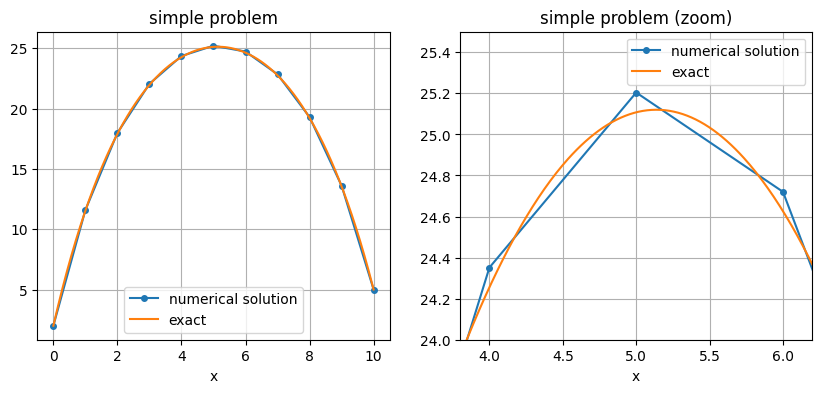

In [9]:
# number of elements
N = 10
# number of points
Npts = N+1

# create mesh
x = np.linspace(0,L,Npts)
dx = np.diff(x)

# build matrix
A = sparse.lil_matrix((Npts,Npts))
b = np.zeros(Npts)
# loop over interior vertices
for i in range(1,Npts-1):
    A[i,i-1] = -D/dx[i-1] + sigma*dx[i-1]/6
    A[i,i+1] = -D/dx[i]   + sigma*dx[i]  /6
    A[i,i] = D/dx[i-1] + D/dx[i] + sigma*dx[i-1]/3 + sigma*dx[i]/3
    b[i] = q*(dx[i-1]+dx[i])/2
# boundary conditions
A[0,0] = 1        
A[-1,-1] = 1        
b[0] = u_left
b[-1] = u_right
# solve sparse system of equations
u = linalg.spsolve(A.tocsc(), b)

# plot
fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(x,      u, marker='o', ms=4, label='numerical solution')
axs[0].plot(x_fine, exact(x_fine), label='exact')
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel('x')
axs[0].set_title('simple problem')

# zoom
axs[1].plot(x,      u, marker='o', ms=4, label='numerical solution')
axs[1].plot(x_fine, exact(x_fine), label='exact')
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlabel('x')
axs[1].set_title('simple problem (zoom)')
axs[1].set_xlim([3.8,6.2])
axs[1].set_ylim([24,25.5])
plt.show()

## The above was not entirely done in the FE philosophy: let's correct this

The biggest issue is that we have computed the integrals over the entire domain for each test function $b_i(x)$. This is not scalable to multi-dimensional unstructured meshes. 

Let us go back to this stage:
$$ -\left.b_{\text{test}}(x)D\frac{du_h}{dx}\right|_L + \left.b_{\text{test}}(x)D\frac{du_h}{dx}\right|_0 + \sum_{j=0}^{j=N} \int_0^L dx \, \left( \frac{db_{\text{test}}}{dx}Du_j\frac{db_j}{dx} + b_{\text{test}}\sigma u_jb_j \right) = \int_0^L dx \, \left( b_{\text{test}}(x) q \right)$$

We replace the integral over the entire domain by a sum over elements of the integral over each element:
$$ \int_0^L dx  \ldots \quad\longrightarrow\quad  \sum_{K} \int_{\text{element}_K} dx \ldots $$

Ignoring the boundary terms for now, we have

$$ \underbrace{\sum_{j=0}^{j=N} \sum_{K} \int_{\text{element}_K} \, \left( \frac{db_{\text{test}}}{dx}Du_j\frac{db_j}{dx} + b_{\text{test}}\sigma u_jb_j \right)}_{\textbf{On the left hand side}} \textbf{ and } \underbrace{\sum_{K} \int_{\text{element}_K} dx \, \left( b_{\text{test}}(x) q \right)}_{\textbf{On the right hand side}}$$


Let us designate one element $K$. Say, $K = [x_{i},x_{i+1}]$.
1. The only two test functions that are not zero over element $K$ are $b_i(x)$ (test=$i$) and $b_{i+1}(x)$ (test=$i+1$)
2. The only two basis functions (indexed by $j$) that are not zero over element $K$ are $b_i(x)$ (when $j=i$) and $b_{i+1}(x)$ when ($j=i+1$)

So, the integrals over element $K$ 
1. will contribute to rows $i$ and $i+1$ of the global matrix and 
2. will only deal with unknowns $i$ and $i+1$ of the solution vector

Therefore, we create a **connectivity array** that, for each element index, it returns the global indices (or global numbering, or `gn`)
$$ gn[K] = [i, i+1] $$

We now only need to focus on the integration over a single element $K$:

$$ \underbrace{\int_{\text{element}_K} \, \left( \frac{db_{\hat i}}{dx}D\frac{db_{\hat j}}{dx} + b_{\hat i}\sigma b_{\hat j} \right)}_{\textbf{Integration on the left hand side for element}_{K}} \textbf{and} \underbrace{\int_{\text{element}_K} dx \, \left( b_{\hat i}(x)\, q \right)}_{\textbf{Integration on the right hand side for element}_{K}}$$

I have introduced the **local** element indices ${\hat i}$ and ${\hat j}$. They both are equal to either 0 or 1 as there are only two functions intersecting a given element and I started numbering at 0 in the style of python.

Now, we can carry those integrals on each element $[x_{i},x_{i+1}]$ but we prefer to do a change of variables to a reference element. So, insteading of integrating over $x$ for any element $[x_{i},x_{i+1}]$ we will integrate over $s$ for a fixed (reference) element:

$$ x = \frac{x_{i}+x_{i+1}}{2} + s \frac{x_{i+1}-x_{i}}{2} $$
where 
$$ -1 \le s \le 1$$

On the reference element the basis and test functions are:
$$
b_0(s) = \frac{1-s}{2}
$$
and
$$
b_1(s) = \frac{1+s}{2}
$$

Note that
$$ \frac{db(x)}{dx} = \frac{db(s)}{ds}\frac{ds}{dx} = \frac{db(s)}{ds}\frac{2}{x_{i+1}-x_{i}} = \frac{db(s)}{ds}\frac{2}{h_{K}}$$
and that
$$ dx = \frac{x_{i+1}-x_{i}}{2} ds = \frac{h_{K}}{2} ds$$

Finally, the elemental integrals transformed into a reference element are:

For the diffusion term:
$$\int_{\text{element}_K} \, \frac{db_{\hat i}}{dx}D\frac{db_{\hat j}}{dx} dx
=  D \int_{-1}^{+1}\, \frac{2}{h_{K}}\frac{db_{\hat i}(s)}{ds} \frac{2}{h_{K}}\frac{db_{\hat j}(s)}{ds}\frac{h_{K}}{2} ds
= \frac{2}{h_{K}} D  \int_{-1}^{+1}ds\, \frac{\mp 1}{2} \frac{\mp 1}{2}
$$
We compute
$$
\int_{-1}^{+1}ds\, \frac{\mp 1}{2} \frac{\mp 1}{2}
=
\begin{bmatrix}
\frac{1}{2} & -\frac{1}{2} \\
-\frac{1}{2} & \frac{1}{2} 
\end{bmatrix} = \mathbf{K}$$

For the reaction term,

$$\int_{\text{element}_K} dx\, \sigma b_{\hat i} b_{\hat j} 
= \sigma\frac{h_{K}}{2} \int_{-1}^{+1}ds\, b_{\hat i}(s) b_{\hat j}(s)
= \sigma\frac{h_{K}}{2} \int_{-1}^{+1}ds\, \frac{1\mp s}{2} \frac{1\mp s}{2}
$$
We compute
$$
\int_{-1}^{+1}ds\, \frac{1\mp s}{2} \frac{1\mp s}{2}
=
\begin{bmatrix}
\frac{2}{3} & \frac{1}{3} \\
\frac{1}{3} & \frac{2}{3} 
\end{bmatrix}= \mathbf{M}$$


For the source term,

$$\int_{\text{element}_K} dx\, q b_{\hat i} 
= q\frac{h_{K}}{2} \int_{-1}^{+1}ds\, b_{\hat i}(s) 
= q\frac{h_{K}}{2} \int_{-1}^{+1}ds\, \frac{1\mp s}{2}
$$
We compute
$$
\int_{-1}^{+1}ds\, \frac{1\mp s}{2} 
=
\begin{bmatrix}
1 \\
1 
\end{bmatrix}= \mathbf{f}$$


Denoting the half-volume of element $K$ by $|J_K|=\frac{h_K}{2}$, the elemental contributions are:
1. to the global matrix:
$$ \frac{D}{|J_K|}\mathbf{K} + \sigma|J_K| \mathbf{M}$$
2. to the global right-hand side:
$$ q|J_K| \mathbf{f}$$


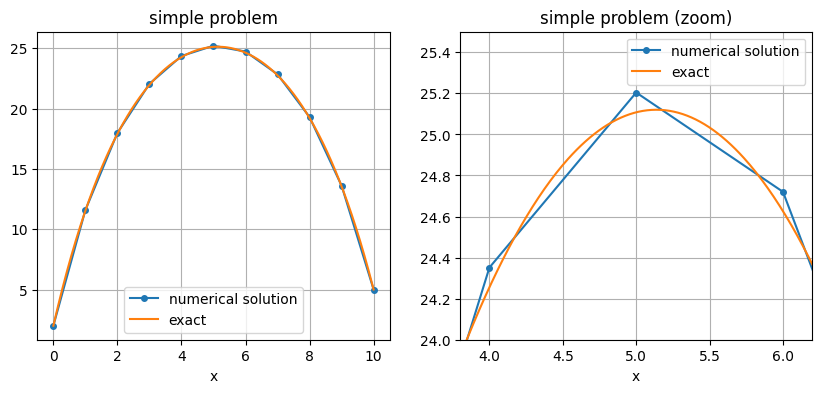

In [10]:
# number of elements
Nelem = len(x) - 1
Ndofs = Nelem+1
# create mesh
x = np.linspace(0,L,Ndofs)
J = np.diff(x)/2

# connectivity array
gn = np.zeros((Nelem,2),dtype=int)
gn[0,:]=[0,1]
for iel in range(1,Nelem):
    gn[iel,0] = gn[iel-1,-1]
    gn[iel,1] = gn[iel,0] + 1 

# elemental matrices/vectors
K,M,f = np.zeros((2,2)), np.zeros((2,2)), np.ones(2)
K[0,:] = [0.5,-0.5]
K[1,:] = [-0.5,0.5]
M[0,:] = [2,1]
M[1,:] = [1,2]
M /= 3

# build matrix
A = sparse.lil_matrix((Ndofs,Ndofs))
b = np.zeros(Ndofs)

# loop over elements
for iel in range(0,Nelem):
    # global indices
    g = gn[iel,:]
    # add matrix contribution 
    local_mat = D/J[iel]*K + sigma*J[iel]*M
    for i,ind_i in enumerate(gn[iel,:]):
        b[ind_i] += q*J[iel]*f[i]
        for j,ind_j in enumerate(gn[iel,:]):
            A[ind_i,ind_j] += local_mat[i,j] 
# boundary conditions
A[0,:] = 0
A[0,0] = 1
A[-1,:] = 0        
A[-1,-1] = 1        
b[0] = u_left
b[-1] = u_right
# solve sparse system of equations
u = linalg.spsolve(A.tocsc(), b)

# plot
fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(x,      u, marker='o', ms=4, label='numerical solution')
axs[0].plot(x_fine, exact(x_fine), label='exact')
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel('x')
axs[0].set_title('simple problem')

# zoom
axs[1].plot(x,      u, marker='o', ms=4, label='numerical solution')
axs[1].plot(x_fine, exact(x_fine), label='exact')
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlabel('x')
axs[1].set_title('simple problem (zoom)')
axs[1].set_xlim([3.8,6.2])
axs[1].set_ylim([24,25.5])
plt.show()